#### In planet data, make sure that filename matches annotation

In [ ]:
import os
from glob import glob

def fix_path(path: str) -> str:
    return path.replace("\\", "/")

labels_dir = fix_path("datasets\Planet\labels")
source_dir = fix_path("datasets\Planet\source")

labels = sorted([os.path.splitext(i)[0] for i in glob(os.path.join(labels_dir, "*.geojson"))])
source = sorted([os.path.splitext(i)[0] for i in glob(os.path.join(source_dir, "*.jpg"))])

# Compare the two lists and make sure that the list items are the same
print(all([os.path.basename(i) == os.path.basename(j) for i, j in zip(labels, source)]))

True


#### Ananya's code

In [ ]:
import os
import json

def fix_path(path: str) -> str:
    return path.replace("\\", "/")

images_dir = fix_path("datasets\Planet\source")
labels_dir = fix_path("datasets\Planet\labels")
output_dir = fix_path("datasets\Planet\yolo_labels")

class_map = {
    "marine_debris": 0  # Add more classes if needed, with unique IDs
}

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Function to normalize coordinates
def normalize_bbox(bbox, img_width, img_height):
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return x_center, y_center, width, height

# Loop through GeoJSON files
for filename in os.listdir(labels_dir):
    if filename.endswith(".geojson"):
        geojson_path = os.path.join(labels_dir, filename)

        # Load GeoJSON
        with open(geojson_path, "r") as f:
            data = json.load(f)

        # Extract image filename
        base_name = os.path.splitext(filename)[0]
        image_path = os.path.join(images_dir, base_name + ".jpg")  # Update extension if needed

        # Check if image exists
        if not os.path.exists(image_path):
            print(f"Image not found for {base_name}, skipping...")
            continue

        # Get image dimensions
        with Image.open(image_path) as img:
            img_width, img_height = img.size

        # Create YOLO label file
        yolo_file_path = os.path.join(output_dir, base_name + ".txt")
        with open(yolo_file_path, "w") as yolo_file:
            # Iterate through features
            for _, row in data.iterrows():
                # Access the 'name' column directly
                class_name = row.get("name", None)  # Replace 'name' with the exact column name if different
                if class_name not in class_map:
                    print(f"Class {class_name} not in class_map, skipping...")
                    continue

                class_id = class_map[class_name]
                geometry = row.geometry

                # Get bounding box
                if geometry and geometry.is_valid:
                    bbox = geometry.bounds  # (minx, miny, maxx, maxy)
                    x_center, y_center, width, height = normalize_bbox(bbox, img_width, img_height)

                    # Write to YOLO file
                    yolo_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print("Conversion complete!")



datasets/Planet/labels


Code to check for all the unique labels

In [ ]:
import json
import os
from glob import glob

# Read sample file as a dictionary
labels_path = fix_path(r"datasets\Planet\labels")
label_files = glob(os.path.join(labels_path, "*.geojson"))

class_map = {
    "marine_debris": 0  # Add more classes if needed, with unique IDs
}

labels = []
coords = []

# Indiscriminately loop through all GeoJSON files without separating by file for exploratory purposes
for file in label_files:
    with open(file, "r") as f:
        data = json.load(f)

    for feature in data["features"]:
        label = class_map[feature["properties"]["name"]]
        labels.append(label)

        coordinates = feature["geometry"]["coordinates"][0][:-1]
        coords.append(coordinates)

print(set(labels))
print(*coords[:5], sep="\n")

{0}
[[-87.623357, 15.975562], [-87.621791, 15.975562], [-87.621791, 15.974811], [-87.623357, 15.974811]]
[[-87.621907, 15.977172621632805], [-87.6214599609375, 15.977172621632805], [-87.6214599609375, 15.975994], [-87.621907, 15.975994]]
[[-87.622971, 15.961329081596643], [-87.6214599609375, 15.961329081596643], [-87.6214599609375, 15.958825], [-87.622971, 15.958825]]
[[-87.623906, 15.956811], [-87.623906, 15.95604762305055], [-87.626953125, 15.95604762305055], [-87.626953125, 15.956811]]
[[-87.624236, 15.951041], [-87.623361, 15.951041], [-87.623361, 15.950766025306109], [-87.624236, 15.950766025306109]]


Um, seems like the coords are in order of top_left, top_right, bottom_right, bottom_left. Realized that each point is in [longitude, latitude] format, and I checked all this via opening the image on QGIS and checking coord points. This complicates things.

#### Inspect metadata of the image for any border coords

In [ ]:
import rasterio

test_tif = fix_path(r"datasets\Planet\source\20160928_153233_0e16_16816-29821-16.tif")

with rasterio.open(test_tif) as src:
    # print(src.profile)
    bounds = src.bounds

left, bottom, right, top = bounds
print(left, bottom, right, top)


-87.626953125 15.971891580928972 -87.6214599609375 15.977172621632805


#### Hmm, image metadata for coords is ridiculously complicated. Longitude latitude needs to be changed to row, column format. Then the order needs to be changed. Then top-left bottom-right needs to be obtained. Then normalized.
#### Let's try numpy files, since they're also given.

In [ ]:
import numpy as np

# Read npy file
test_file = fix_path(r"datasets\Planet\labels\20160928_153233_0e16_16816-29821-16.npy")
data: np.ndarray = np.load(test_file, allow_pickle=True)

print(data.tolist())

[[163, 74, 244, 118, 1], [230, 0, 255, 61, 1]]


Evidently, npy files work better? documentation.pdf in the datasets/Planet directory says it's perfectly in <b>[xmin, ymin, xmax, ymax, class_id]</b> form.  I need to make sure there's one file per jpg

In [ ]:
import os
from glob import glob

def fix_path(path: str) -> str:
    return path.replace("\\", "/")

labels_dir = fix_path("datasets\Planet\labels")
source_dir = fix_path("datasets\Planet\source")

labels = sorted([os.path.splitext(i)[0] for i in glob(os.path.join(labels_dir, "*.npy"))])
source = sorted([os.path.splitext(i)[0] for i in glob(os.path.join(source_dir, "*.jpg"))])

# Compare the two lists and make sure that the list items are the same
print(all([os.path.basename(i) == os.path.basename(j) for i, j in zip(labels, source)]))

True


Flawless. Now, we just need to move the npy info to a txt, normalize the coords and re-order to make it [class_id, xcenter, y_center, width, height]. All the code is here

#### Resizing and histogram stretch

In [12]:
import os
from tqdm import tqdm

base_dataset_dir = "datasets/Planet/"
source_dir = base_dataset_dir + "source/"

source_files = glob(source_dir + "*.tif")

# Store all file sizes
count = 0
for file in tqdm(source_files):
    print(file, f"{count:06d}_{file}")
    count += 1
    # os.rename(file, f"{count:06d}_{file}")

100%|██████████| 739/739 [00:00<00:00, 134262.79it/s]

datasets/Planet/source\20160928_153233_0e16_16816-29821-16.tif 000000_datasets/Planet/source\20160928_153233_0e16_16816-29821-16.tif
datasets/Planet/source\20160928_153233_0e16_16816-29824-16.tif 000001_datasets/Planet/source\20160928_153233_0e16_16816-29824-16.tif
datasets/Planet/source\20160928_153233_0e16_16816-29825-16.tif 000002_datasets/Planet/source\20160928_153233_0e16_16816-29825-16.tif
datasets/Planet/source\20160928_153233_0e16_16816-29828-16.tif 000003_datasets/Planet/source\20160928_153233_0e16_16816-29828-16.tif
datasets/Planet/source\20160928_153233_0e16_16816-29829-16.tif 000004_datasets/Planet/source\20160928_153233_0e16_16816-29829-16.tif
datasets/Planet/source\20160928_153233_0e16_16816-29830-16.tif 000005_datasets/Planet/source\20160928_153233_0e16_16816-29830-16.tif
datasets/Planet/source\20160928_153233_0e16_16816-29831-16.tif 000006_datasets/Planet/source\20160928_153233_0e16_16816-29831-16.tif
datasets/Planet/source\20160928_153233_0e16_16817-29821-16.tif 000007

In [ ]:
import os
from glob import glob
import rasterio
import numpy as np
from tqdm import tqdm


def histogram_stretch(image: np.ndarray) -> np.ndarray:
    # Normalize the image for each band
    for i in range(image.shape[2]):
        band = image[:, :, i]
        band_min, band_max = band.min(), band.max()
        image[:, :, i] = (band - band_min) / (band_max - band_min) * 255

    return image
    

base_dataset_dir = "datasets/Planet/"
source_dir = base_dataset_dir + "source/"
histogram_dir = base_dataset_dir + "source_histogram/"

os.makedirs(histogram_dir, exist_ok=True)

source_files = glob(source_dir + "*.tif")

# Store all file sizes
for file in tqdm(source_files):
    with rasterio.open(file, driver="Gtiff") as src:
        # Read image
        img = src.read().transpose(1, 2, 0)
        metadata = src.meta

        # Stretch image histogram
        img = histogram_stretch(img).astype(np.uint8)

        # Save image
        img_path = histogram_dir + os.path.basename(file)
        with rasterio.open(img_path, "w", **metadata) as dst:
            dst.write(img.transpose(2, 0, 1))

  0%|          | 0/739 [00:00<?, ?it/s]

100%|██████████| 739/739 [00:12<00:00, 61.35it/s]


#### Move jpg images to a diff folder

In [2]:
import os
import shutil
from glob import glob

source_folder = "datasets/Planet/jpg_source"
txt_folder = "datasets/Planet/yolo_labels"

images = sorted(glob(source_folder + "/*.jpg"))
txt_files = sorted(glob(txt_folder + "/*.txt"))

assert len(images) == len(txt_files), "Number of images and text files do not match"

for image, label in zip(images, txt_files):
    image_name = os.path.splitext(os.path.basename(image))[0]
    label_name = os.path.splitext(os.path.basename(label))[0]

    assert image_name == label_name, f"Image and label names do not match: {image_name} != {label_name}"

#### Augmentation code

In [78]:
import albumentations as A
import cv2
import numpy as np
from typing import Tuple, List


def get_image(image_path: str) -> Tuple[np.ndarray, Tuple[int, int]]:
    """Read image and return the image array along with size tuple.

    Args:
        image_path (str): Image path.

    Returns:
        Tuple[np.ndarray, Tuple[int, int]]: Pair of image and its dimensions.
    """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image, image.shape


def get_boxes(label_path: str, size: Tuple[int, int]) -> List[List[int]]:
    with open(label_path, "r") as f:
        lines = f.readlines()
    lines = [[float(j) for j in i.split()[1:]] + ["0"] for i in lines]
    return lines

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
    ],
    bbox_params=A.BboxParams(format="yolo"),
)

image_path = "datasets/Planet/dataset_splits/train/images/20160928_153233_0e16_16816-29821-16.jpg"
label_path = "datasets/Planet/dataset_splits/train/labels/20160928_153233_0e16_16816-29821-16.txt"

original_image, size = get_image(image_path)
original_bboxes = get_boxes(label_path, size)

print(original_bboxes)

[[0.794922, 0.375, 0.316406, 0.171875, '0'], [0.947266, 0.119141, 0.097656, 0.238281, '0']]


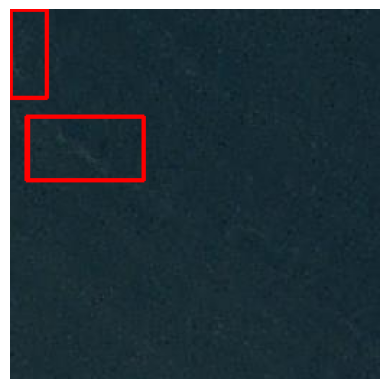

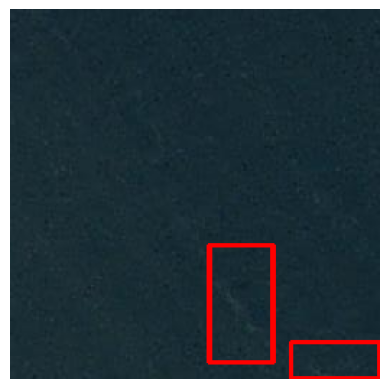

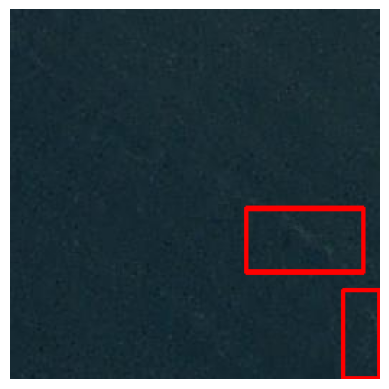

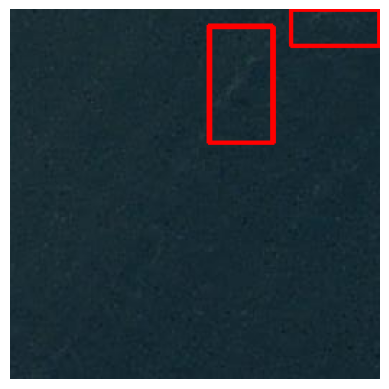

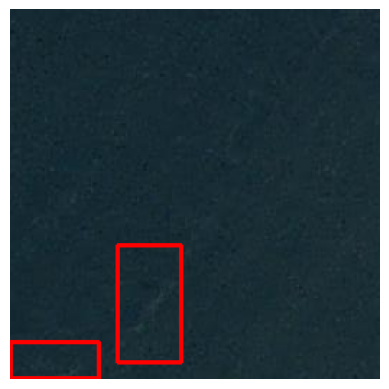

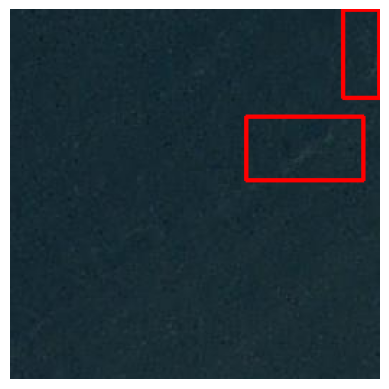

In [84]:
import matplotlib.pyplot as plt


def visualize(image: np.ndarray, bboxes: List[List[int]]):
    for bbox in bboxes:
        x, y, w, h, _ = bbox
        x1, y1 = int((x - w / 2) * image.shape[1]), int((y - h / 2) * image.shape[0])
        x2, y2 = int((x + w / 2) * image.shape[1]), int((y + h / 2) * image.shape[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def augment_images(original_image: np.ndarray, original_bboxes: List[List[int]]):
    images_list = []
    bboxes_list = []
    counter = 0
    while counter < 5:
        transformed = transform(image=original_image, bboxes=original_bboxes)
        transformed_image = transformed["image"]
        transformed_bboxes = transformed["bboxes"]
        
        # Check for uniqueness by comparing the transformations
        unique = True
        for img, bbox in zip(images_list, bboxes_list):
            if np.array_equal(transformed_image, img) and transformed_bboxes == bbox:
                unique = False
                break
        
        if np.array_equal(transformed_image, original_image) and transformed_bboxes == original_bboxes:
            unique = False
        
        if unique:
            images_list.append(transformed_image)
            bboxes_list.append(transformed_bboxes)
            counter += 1

    return images_list, bboxes_list




# ---------------------------------------------------------------------------